# Imports and Settings

In [882]:
from datetime import datetime as dt
from matplotlib import pyplot as plt
import numpy as np
import math
import numba as nb

In [883]:
N_FREQUENCY_CHANNELS = 4096 # Must be power of 2
N_TIME_SAMPLES = 4096 # Must be >= N_FREQUENCY_CHANNELS

# Upper bound of the FRB
UPPER_BOUND = np.random.random()*N_FREQUENCY_CHANNELS

# Lower bound of the FRB
LOWER_BOUND = np.random.random()*UPPER_BOUND

LOWER_BOUND = 0
UPPER_BOUND = N_FREQUENCY_CHANNELS

# RFI intensitiy will be in range [0, RFI_STRENGTH)
RFI_STRENGTH = 0

# FRB intensity will be in range [FRB_MIN_STRENGTH, FRB_MAX_STRENGTH)
FRB_MAX_STRENGTH = 1
FRB_MIN_STRENGTH = 1

# Experimental
ADD_FRB_NOISE = False
FRB_NOISE_STRENGTH = 0

EMPHASIZE = False
LOW_FILTER = False

LOW_FILTER_MAX = 5

# Create Data
## Create the data with the background noise

In [884]:
data = np.random.random( (N_FREQUENCY_CHANNELS, N_TIME_SAMPLES) )*RFI_STRENGTH

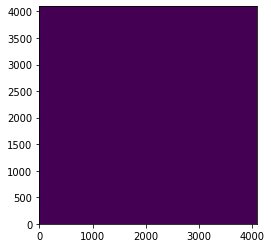

In [885]:
plt.imshow(data, origin="lower")
plt.show()

## Draw a line in the data

In [886]:
# Draws a line in the data given the lines slope and y incercept
def draw_line(data, m, X):
    for y in range(LOWER_BOUND, UPPER_BOUND):
        data[int(y)][int(m*y+X)] = np.random.random()*( FRB_MAX_STRENGTH-FRB_MIN_STRENGTH ) + FRB_MIN_STRENGTH
    
    return data
    

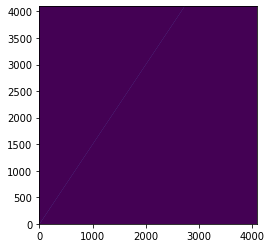

In [887]:
m = math.tan(np.random.random()*math.pi/4 + math.pi/4) # Choose a ranom slope in range [PI/4, PI/2)
x_intercept = np.random.random()*N_TIME_SAMPLES # Choose a random x intercept in range [0, N_SAMPLES)

m = 1.5
x_intercept = 10

data = draw_line(data, 1/m, x_intercept) # Draw the line

plt.imshow(data, origin="lower")
plt.show()

# FRB Detection

In [888]:
@nb.jit(nopython=True, parallel=True)
def filter(data):
    n =  ( N_FREQUENCY_CHANNELS*FRB_MAX_STRENGTH )**7

    for x in range( N_TIME_SAMPLES ):
        for y in range( N_FREQUENCY_CHANNELS ):
            if LOW_FILTER and data[y][x] <= LOW_FILTER_MAX:
                data[y][x] = 0
            elif EMPHASIZE:
                data[y][x] = data[y][x]**10 / n
    
    return data

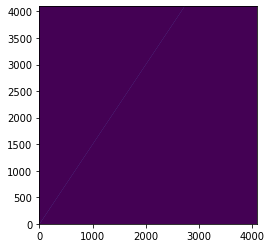

In [889]:
data = filter(data)
plt.imshow(data, origin="lower")
plt.show()

In [890]:
def line_detection_slosar(data):
    todo = [data]
    while todo[0].shape[0]>1:
        outdo = []
        for subar in todo:
            Nf, Nt = subar.shape
            assert(Nf%2 == 0)
            Nfhalf = Nf //2
            vert = np.array([subar[2*i,:]+subar[2*i+1,:] for i in range(Nfhalf)])
            diag = np.array([subar[2*i,i:-Nfhalf+i-1]+subar[2*i+1,i+1:-Nfhalf+i] for i in range(Nfhalf)])
            outdo.append(vert)
            outdo.append(diag)
        todo = outdo
    outar = np.zeros_like(data)
    Nf = data.shape[0]
    for i,line in enumerate(outdo):
        outar[i,:line.shape[1]] = line[0,:]
    return outar
    
def line_detection_brandon(data, i):
    Nc = 2**i # Number Of Channels
    Ch = N_TIME_SAMPLES//Nc # Channel Height

    if Ch > 1:
        Cw = data.shape[1] # Channel Width
        f = lambda i: data[2*i,i:-Ch//2+i-1] + data[2*i+1,i+1:-Ch//2+i]

        vert = line_detection_brandon(data[0:Ch:2] + data[1:Ch+1:2], i+1)
        diag = line_detection_brandon(np.array([ f(i) for i in range(Ch//2) ]), i+1)

        data[0:Ch//2, :] = vert
        data[Ch//2:Ch, 0:diag.shape[1]] = diag
        data[Ch//2:Ch, diag.shape[1]:Cw] = 0

    return data



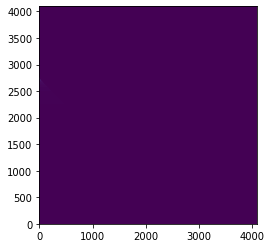

Mr. Slosars Function Takes:  0:00:01.610448


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(undefined, 1d, C), int64, array(float64, 1d, C))
 
There are 16 candidate implementations:
[1m      - Of which 16 did not match due to:
      Overload of function 'setitem': File: <numerous>: Line N/A.
        With argument(s): '(array(undefined, 1d, C), int64, array(float64, 1d, C))':[0m
[1m       No match.[0m
[0m
[0m[1mDuring: typing of setitem at <ipython-input-890-479283c0f254> (30)[0m
[1m
File "<ipython-input-890-479283c0f254>", line 30:[0m
[1mdef line_detection_brandon(data, i):
    <source elided>
        vert = line_detection_brandon(data[0:Ch:2] + data[1:Ch+1:2], i+1)
[1m        diag = line_detection_brandon(np.array([ f(i) for i in range(Ch//2) ]), i+1)
[0m        [1m^[0m[0m


In [891]:
start = dt.now()
res = line_detection_slosar(data)
plt.imshow(res, origin="lower")
plt.show()
end = dt.now()

print("Mr. Slosars Function Takes: ", end - start)

start = dt.now()
res = line_detection_brandon(data, 0)
plt.imshow(res, origin="lower")
plt.show()
end = dt.now()

print("Brandons Function takes: ", end - start)



In [870]:
Mx = My = 0
for y in range(N_FREQUENCY_CHANNELS):
    for x in range(N_TIME_SAMPLES):
        if data[y][x] > data[My][Mx]:
            Mx = x
            My = y
            

In [871]:
print(Mx, My)

10 2729
